<a href="https://colab.research.google.com/github/r-diazp/covid19/blob/master/time_series_covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![pytorch icon.png](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQWyV5brHNCcNRsfWARFMR78N0Wg5V2hksMVYQeOpYnBn4zKOX2PPWky9wqxVoXuvnUi_s&usqp=CAU)

- Understanding LSTM Networks https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Fuente https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
For each element in the input sequence, an LSTM layer computes the following functions:<br>
$\begin{array}{ll} \\
    i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{(t-1)} + b_{hi}) \\
    f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{(t-1)} + b_{hf}) \\
    g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{(t-1)} + b_{hg}) \\
    o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{(t-1)} + b_{ho}) \\
    c_t = f_t * c_{(t-1)} + i_t * g_t \\
    h_t = o_t * \tanh(c_t) \\
\end{array}$ 

<br>$i_t, f_t, g_t, o_t$ are the input, forget, cell, and output gates, respectively.<br>
$h_t$ is the hidden state at time $t$, <br>
$c_t$ is the cell state at time $t$, <br>
$h_{(t-1)}$ is the hidden state of the layer at time $t-1$ or the initial hidden state at time $0$, and <br>
$x_t$ is the input at time $t$, <br>

# Librerias y Funciones

In [ ]:
import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.preprocessing import MinMaxScaler
from dateutil.relativedelta import relativedelta
import time

from google.colab import auth, drive
from google.cloud import bigquery
auth.authenticate_user()
drive.mount("/content/drive")
project_id = input('Ingresar project_id (Google Cloud): ')

In [20]:
#Revisar si la GPU esta habilitda y modelo 
print(f'- GPU available: {torch.cuda.is_available()} \
      \n- GPU: {torch.cuda.get_device_name(0)}')

- GPU available: True       
- GPU: Tesla K80


In [57]:
#Determinar casos diarios (Ya que los datos vienen acumulados)
def daily_cases(data_frame):
  daily_cases, j = [], 0
  for j in range(len(data_frame) ):
    if j==0:
      daily_cases.append(data_frame[j:j+1].item() )
    else:  
      daily_cases.append(data_frame[j:j+1].item() - data_frame[j-1:j].item() )
  return np.array(daily_cases)

#Determinar ventana 
def input_data(sequence, windows_size):  #Windows_size tamaño de la ventana 
  output = []
  L = len(sequence)
  for i in range(L - windows_size):
      window = sequence[i : i + windows_size]
      label = sequence[i + windows_size : i + windows_size+1]
      output.append((window, label))
  return output


#Funcion para entrenamiento de modelos
def model_fit(epochs, data, model, criterion, optimizer, num_layers=1):
  losses = []
  start_time = time.time()
  for epoch in range(epochs):    
      # Extraer sequence & target de los datos de entrenamiento 
      
      for sequence, target in data:        
        # Resetear el estado de los parametros de la capa oculta 
        optimizer.zero_grad()
        model.hidden = (torch.zeros(num_layers, 1, model.hidden_size).cuda(),
                        torch.zeros(num_layers, 1, model.hidden_size).cuda())
        
        #Hacer predicciones con el modelo 
        prediction = model(sequence) 
        
        #Back Propagation
        loss = criterion(prediction, target)
        loss.backward()
        optimizer.step()
      
      losses.append(loss)        
      
      #Imprimir resultados del entrenamiento (cada 25 epocas)
      if epoch%10 == 1: 
        print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')    

  print(f'\nLoss: {loss.item():10.8f}')  
  print(f'\nDuration: {time.time() - start_time:.0f} seconds')

  #Grafica de convergencia del entrenamiento
  plt.figure(figsize = (10,5)) 
  plt.plot(range(epochs), losses)
  plt.ylabel('Loss')
  plt.xlabel('Epochs');
  plt.grid(True)

In [22]:
# Consulta a Bigquery y cargamos los datos a un DataFrama 
%%bigquery --project $project_id2 df_covid
SELECT * 
  FROM bigquery-public-data.covid19_jhu_csse.summary
  WHERE country_region = 'Guatemala' 
  ORDER BY date ASC

# Procesar Datos

In [23]:
#DataFrame 
columns = ['date', 'confirmed', 'deaths' , 'recovered']
df = df_covid[columns]
df = df.fillna(0)
df['daily_confirmed'] = daily_cases(df['confirmed'].values) #Calcular casos confirmados por dia
df['daily_deaths'] = daily_cases(df['deaths'].values) #Calcular bajas por dia
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.index.freq = 'D'
df.head()

,confirmed,deaths,recovered,daily_confirmed,daily_deaths
date,,,,,
2020-03-14,1,0,0.0,1,0
2020-03-15,1,0,0.0,0,0
2020-03-16,2,1,0.0,1,1
2020-03-17,6,1,0.0,4,0
2020-03-18,6,1,0.0,0,0


In [ ]:
#Grafica de los datos 
target_column = "daily_confirmed" #@param {type:"string"}
month_show =  8#@param {type:"number"}
title = target_column
ylabel = target_column
figsize = (25,6)

ax = df[target_column][-30*month_show:].plot(figsize=figsize, title=title)
ax.autoscale(axis='x', tight=False)
ax.set(ylabel=ylabel)
ax.grid()

#Descomposicion de la serie temporal 
print('\nDescomposicion de la serie temporal ')
result = seasonal_decompose(df[target_column])
result.plot( );


In [126]:
#PREPAR DATOS 
# Crear datos de entrnamiento y test (#8 dias, 16 test)
target = df[target_column].values.astype(float)
window_size = 8
test_size = 16
train_set = target[:-test_size]
test_set = target[-test_size:]

# Normalizar los datos (https://en.wikipedia.org/wiki/Feature_scaling)
scaler = MinMaxScaler(feature_range=(-1, 1))
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

# Datos de entranmiento 
train_norm = torch.FloatTensor(train_norm).view(-1).cuda() #https://pytorch.org/docs/stable/tensor_view.html
train_data = input_data(train_norm, window_size)

# Imprimir resultados
print(f'Data - Train: {len(train_set)}')
print(f'Data - Test:  {len(test_set)}')
print(f'\nTENSORS (Data - Train) {len(train_data)}') 
train_data[:3]

Data - Train: 523
Data - Test:  16

TENSORS (Data - Train) 515


[(tensor([-0.9998, -1.0000, -0.9998, -0.9992, -1.0000, -0.9994, -0.9994, -0.9990],
         device='cuda:0'), tensor([-0.9996], device='cuda:0')),
 (tensor([-1.0000, -0.9998, -0.9992, -1.0000, -0.9994, -0.9994, -0.9990, -0.9996],
         device='cuda:0'),
  tensor([-0.9998], device='cuda:0')),
 (tensor([-0.9998, -0.9992, -1.0000, -0.9994, -0.9994, -0.9990, -0.9996, -0.9998],
         device='cuda:0'), tensor([-0.9998], device='cuda:0'))]

# Arquitectura Red Neuronal

In [79]:
class LSTM(nn.Module):
  def __init__(self, input_size=1, output_size=1, hidden_size=100, num_layers=1):
    super().__init__()
    self.hidden_size = hidden_size
    
    # Agrear una celda LSTM :
    if num_layers > 2:
      self.lstm = nn.LSTM(input_size, hidden_size, num_layers = num_layers, dropout = 0.3)      
    else:
      self.lstm = nn.LSTM(input_size, hidden_size, num_layers = num_layers)        

    # Agregar una capa full connect:
    self.linear = nn.Linear(hidden_size, output_size)      

    # Inicializar valores de h0 y c0:
    self.hidden = (torch.zeros(1,1, self.hidden_size),
                    torch.zeros(1,1, self.hidden_size))

  def forward(self,seq):
    lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)      
    
    out = self.linear(lstm_out.view(len(seq), -1))
    return out[-1]  # Solo se requiere los ultimos valores de la ventana  

In [127]:
#Instanciamos el modelo 
#num_layers, num_neurons, output_size = 1, 100
model_parameters, num_layers = [1, 1, 100], 1
torch.manual_seed(101)

#Instanciar modelo 
model = LSTM(*model_parameters, num_layers=num_layers).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(f'- model (cuda): {next(model.parameters()).is_cuda}')
print(f'\nARQUITECTURA: \n{model}')

- model (cuda): True

ARQUITECTURA: 
LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [128]:
#Ejemplo Ho, Co
Ho = torch.zeros(*model_parameters)
Co = torch.zeros(*model_parameters)

#Xt
tensores_mostrar = 5
print(f'-> {tensores_mostrar} PRIMEROS TENSORES DE Xt')
for Xt, y_train in train_data[:tensores_mostrar]:
  print(f'{Xt} ->TAMAÑO DEL TENSOR {len(Xt)} (IGUAL A LA VENTANA)')

print(f'\n-> Ho y Co INICIALIZADOS: \
\nTENSOR Ho: {Ho} ->TAMAÑO DEL TENSOR ES IGUAL A NUMERO DE NEURONAS({model_parameters[2]}) DE LA CELDA LSTM CON DIM = {Ho.dim()} \
\n\nTENSOR Co: {Co} ->TAMAÑO DEL TENSOR ES IGUAL A NUMERO DE NEURONAS({model_parameters[2]}) DE LA CELDA LSTM CON DIM = {Co.dim()}')

-> 5 PRIMEROS TENSORES DE Xt
tensor([-0.9998, -1.0000, -0.9998, -0.9992, -1.0000, -0.9994, -0.9994, -0.9990],
       device='cuda:0') ->TAMAÑO DEL TENSOR 8 (IGUAL A LA VENTANA)
tensor([-1.0000, -0.9998, -0.9992, -1.0000, -0.9994, -0.9994, -0.9990, -0.9996],
       device='cuda:0') ->TAMAÑO DEL TENSOR 8 (IGUAL A LA VENTANA)
tensor([-0.9998, -0.9992, -1.0000, -0.9994, -0.9994, -0.9990, -0.9996, -0.9998],
       device='cuda:0') ->TAMAÑO DEL TENSOR 8 (IGUAL A LA VENTANA)
tensor([-0.9992, -1.0000, -0.9994, -0.9994, -0.9990, -0.9996, -0.9998, -0.9998],
       device='cuda:0') ->TAMAÑO DEL TENSOR 8 (IGUAL A LA VENTANA)
tensor([-1.0000, -0.9994, -0.9994, -0.9990, -0.9996, -0.9998, -0.9998, -0.9994],
       device='cuda:0') ->TAMAÑO DEL TENSOR 8 (IGUAL A LA VENTANA)

-> Ho y Co INICIALIZADOS: 
TENSOR Ho: tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

# Entrenamiento

Epoch:  2 Loss: 0.10141358
Epoch: 12 Loss: 0.10555196
Epoch: 22 Loss: 0.00762387
Epoch: 32 Loss: 0.00020866
Epoch: 42 Loss: 0.00013312
Epoch: 52 Loss: 0.00589494
Epoch: 62 Loss: 0.00277504
Epoch: 72 Loss: 0.01256873

Loss: 0.00389624

Duration: 108 seconds


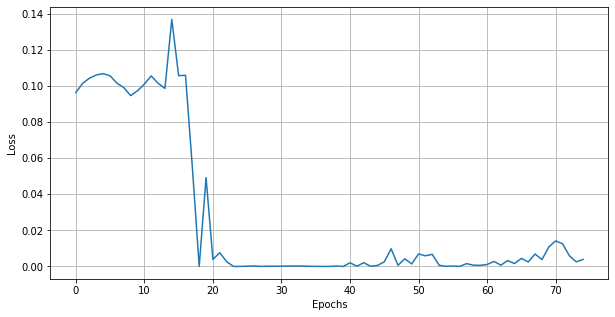

In [82]:
#ENTRENAMIENTO CON DATOS TRAIN
epochs = 75
model.train() 

#Entrenamiento del modelo 
model_fit(epochs, train_data, model, criterion, optimizer, num_layers=num_layers)

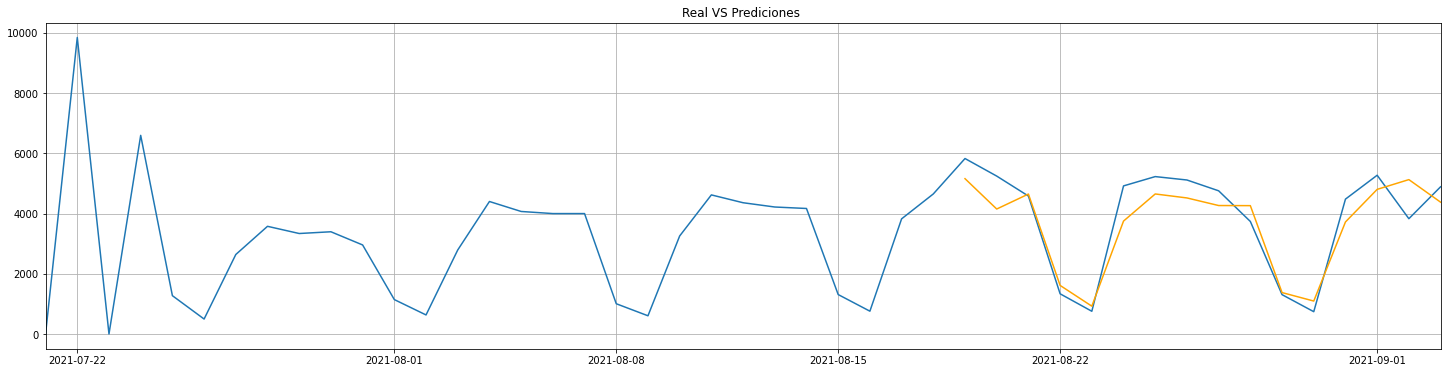

In [83]:
#Evaluar resultados de entrenamiento
future = test_size #Valor a predecir a futuro 
x_train_plot = 45
model.eval() # colocamos el modelo en modo de evaluacion 

# Agregar los valores de entranamiento de la ultima ventana a la lista de predicciones 
pred_test = train_norm[-window_size:].tolist()

for i in range(future):
    sequence = torch.FloatTensor(pred_test[-window_size:]).cuda()
    with torch.no_grad():
        model.hidden = (torch.zeros(num_layers, 1, model.hidden_size).cuda(),
                        torch.zeros(num_layers, 1, model.hidden_size).cuda())
        
        pred_test.append(model(sequence).item())

# Invertimos la normalizacion de los datos 
predictions_test = scaler.inverse_transform(np.array(pred_test[window_size:]).reshape(-1, 1) )

# Grafica comparativo Real VS Prediccion 
x_test_plot = np.array(df.index[-future:], dtype='datetime64[D]')

plt.figure(figsize=figsize)
plt.title('Real VS Prediciones ')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df.iloc[:,3][df.index[-x_train_plot:]])
plt.plot(x_test_plot, predictions_test, "orange")
plt.show()

# Entrenar con todos los datos

Epoch:  2 Loss: 0.05941143
Epoch: 12 Loss: 0.00005261
Epoch: 22 Loss: 0.01875913
Epoch: 32 Loss: 0.01333718
Epoch: 42 Loss: 0.00106758
Epoch: 52 Loss: 0.00012745
Epoch: 62 Loss: 0.00000168
Epoch: 72 Loss: 0.01020711

Loss: 0.00191907

Duration: 111 seconds


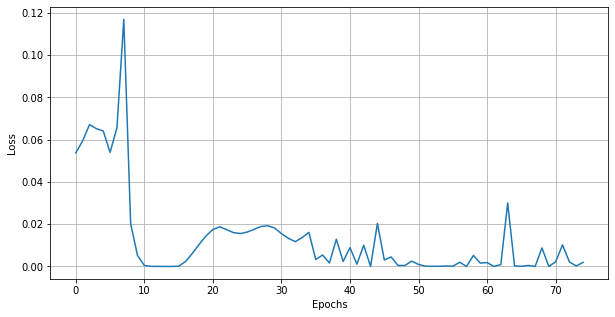

In [130]:
#ENTRENAMIENTO CON TODO LOS DATOS 
model.train() 

# feature scale the entire dataset
target_norm = scaler.fit_transform(target.reshape(-1, 1))
target_norm = torch.FloatTensor(target_norm).view(-1).cuda()
all_data = input_data(target_norm, window_size)

#Entrenamiento del modelo 
model_fit(epochs, all_data, model, criterion, optimizer, num_layers=num_layers)

In [ ]:
#Evaluar resultados de entrenamiento
future = 50 #Valor a predecir a futuro 
model.eval() # colocamos el modelo en modo de evaluacion 

# Agregar los valores de entranamiento de la ultima ventana a la lista de predicciones 
pred_test = train_norm[-window_size:].tolist()

for i in range(future):
    sequence = torch.FloatTensor(pred_test[-window_size:]).cuda()
    with torch.no_grad():
        model.hidden = (torch.zeros(num_layers, 1, model.hidden_size).cuda(),
                        torch.zeros(num_layers, 1, model.hidden_size).cuda())
        
        pred_test.append(model(sequence).item())

# Invertimos la normalizacion de los datos 
predictions_test = scaler.inverse_transform(np.array(pred_test[window_size:]).reshape(-1, 1) )

# Grafica comparativo Real VS Prediccion 
x_train_plot = 5  #Meses
x_test_plot = np.arange(df.index[-1], df.index[-1] + relativedelta(days=+future), dtype='datetime64[D]')
plt.figure(figsize=figsize)
plt.title('Casos diarios covid Guatemala')
plt.ylabel('Confirmados')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df.iloc[:,3][df.index[-x_train_plot*30:]])
plt.plot(x_test_plot, predictions_test, "orange")
plt.show()

In [ ]:
#Resultados 
ini_row = 1
forcast = pd.DataFrame({'date':x_test_plot[ini_row:], 
                        'forcast': predictions_test[ini_row:].flatten()})
forcast['date'] = pd.to_datetime(forcast['date'])
forcast = forcast.set_index('date')
forcast = forcast.astype(int)
forcast.head(50)

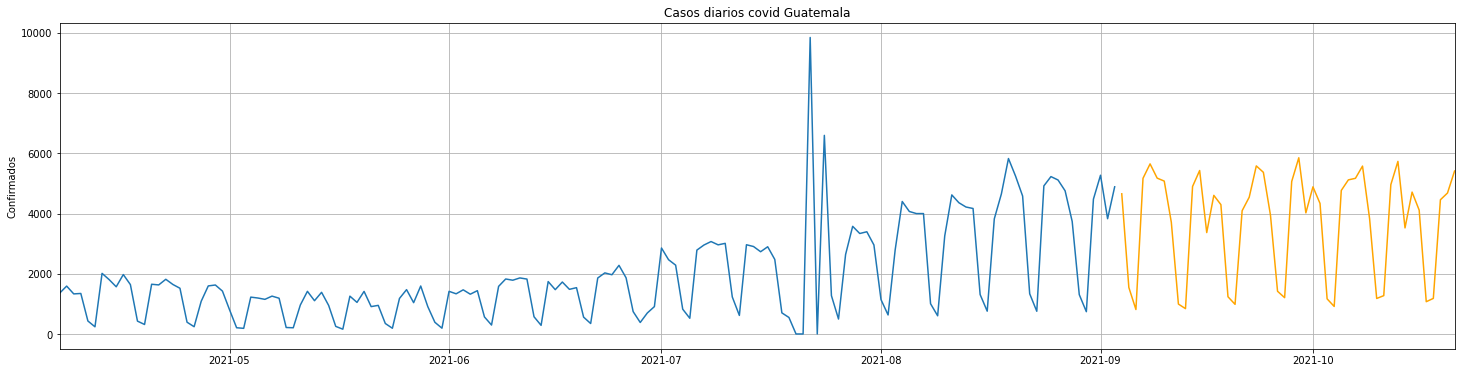

array([4655, 1544,  812, 5169, 5648, 5175, 5077, 3707,  993,  841, 4898,
       5428, 3367, 4603, 4295, 1236,  984, 4093, 4542, 5581, 5368, 3945,
       1418, 1206, 5064, 5851, 4022, 4886, 4334, 1166,  914, 4766, 5117,
       5169, 5575, 3826, 1179, 1273, 4960, 5731, 3522, 4711, 4113, 1072,
       1181, 4457, 4681, 5411])

In [143]:
#Resultados AJUSTADO "Se identifica un desfase de 2 dias"
ini_row = 1
forcast = pd.DataFrame({'date':x_test_plot[1:-1], 
                        'forcast': predictions_test[2:].flatten()})
forcast['date'] = pd.to_datetime(forcast['date'])
forcast = forcast.set_index('date')
forcast = forcast.astype(int)

# Grafica comparativo Real VS Prediccion 
x_train_plot = 5  #Meses
x_test_plot = np.arange(df.index[-1], df.index[-1] + relativedelta(days=+future), dtype='datetime64[D]')
plt.figure(figsize=figsize)
plt.title('Casos diarios covid Guatemala')
plt.ylabel('Confirmados')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df.iloc[:,3][df.index[-x_train_plot*30:]])
plt.plot(forcast.index, forcast['forcast'].values, "orange")
plt.show()
forcast.values.flatten()

In [ ]:
df1 = df[['daily_confirmed']]
df1 = df1.astype(int)
forcast_covid = pd.concat([df1, forcast])
forcast_covid.reset_index(inplace=True)

In [ ]:
#Escribir respultados en BigQuey
forcast_covid.to_gbq('forcast.forcast_covid', 
                     project_id = 'utilitarian-web-324002',
                     if_exists='replace')

1it [00:03,  3.71s/it]


# Actualizar datos

In [145]:
#Escribir respultados en BigQuey
#Crear/actualizar tabla historico
history_covid_gt = df.copy()
history_covid_gt.reset_index(inplace=True)
history_covid_gt.to_gbq('forcast.history_covid_gt', 
             project_id = project_id,
             if_exists='replace')



1it [00:07,  7.00s/it]
1it [00:03,  3.37s/it]


In [ ]:
#Crear/actualizar tabla forecast
forcast_covid_gt = forcast.copy()
forcast_covid_gt.reset_index(inplace=True)
forcast_covid_gt.to_gbq('forcast.forcast_covid_gt', 
             project_id = project_id,
             if_exists='replace')

# Save and load models
Documentation:
https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [146]:
#SAVE MODEL
path = '/content/drive/MyDrive/models/'
torch.save(model.state_dict(), path + '20210904-covid19.pt')

In [ ]:
#LOAD MODEL
#model = TheModelClass(*args, **kwargs)
#model.load_state_dict(torch.load(PATH))
#model.eval()
model.load_state_dict(torch.load(path + '20210829-covid19.pt') )

<All keys matched successfully>